select residues only between DFG and APE to do regression

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from itertools import combinations
from matplotlib.patches import Rectangle

In [ ]:
import pandas as pd

infile  = "conservation_sorted.csv"          
outfile = "conservation_sorted_between_ASP594_GLU623.csv"       

df = pd.read_csv(infile)
df.columns = df.columns.str.strip()         

df["Residue_Number"] = df["Residue"].astype(str).str.extract(r"-(\d+)$").astype(int)
df["Cons_float"] = df["Conservation_Percentage"].astype(str).str.rstrip("%").astype(float)

mask = (df["Residue_Number"] >= 594) & (df["Residue_Number"] <= 623)
sub = df.loc[mask].copy()

sub = sub.sort_values(by=["Cons_float", "Residue_Number"], ascending=[False, True])

sub[["Template_Index", "Residue", "Conservation_Percentage"]].to_csv(outfile, index=False)

print(f"Saved {len(sub)} rows to {outfile}")


Saved 30 rows to conservation_sorted_between_ASP594_GLU623.csv


In [ ]:
"""
This script maps highly conserved residues (≥90% conservation) from a reference alignment to their actual residue numbers in individual PDB files. It cross-references conservation data with alignment information and extracts the corresponding residue indices from PDB files. The final mapping is saved as a CSV file for downstream analysis.

"""

import pandas as pd
import os

# File paths
conservation_file = r"conservation_sorted_between_ASP594_GLU623.csv"
alignment_file = r"alignment_segment_with_index.csv"
mustang_folder = r"Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers"
pdb_folder = r"Results/activation_segments/Mustang_with_singlechain_withoutlier"

output_file = r"conserved_residues_actual_number_DFGAPE.csv"

#Read conservation file and filter for 100% conserved residues
conservation_df = pd.read_csv(conservation_file)
conservation_df['Conservation_Percentage'] = (
    conservation_df['Conservation_Percentage'].str.rstrip('%').astype(float) / 100
)
conserved_df = conservation_df[conservation_df['Conservation_Percentage'] >= 0.90]
template_indices_1_0 = conserved_df['Template_Index'].tolist()

#Read alignment file
alignment_df = pd.read_csv(alignment_file)

#Keep only PDBs that exist in mustang_folder
valid_pdb_names = [os.path.splitext(f)[0] for f in os.listdir(mustang_folder) if f.endswith(".pdb")]

#Filter alignment data for conserved template indices and valid PDB names 
filtered_alignment = alignment_df[
    (alignment_df['Template_Index'].isin(template_indices_1_0)) &
    (alignment_df['PDB_Name'].isin(valid_pdb_names))
]

# Merge to bring in the conserved residue name (Residue column from conservation_df)
filtered_alignment = filtered_alignment.merge(
    conserved_df[['Template_Index', 'Residue']],
    on='Template_Index',
    how='left'
)

#Map Target_Index to actual residue number in the PDB
results = []

for pdb_name, group in filtered_alignment.groupby('PDB_Name'):
    pdb_file_path = os.path.join(pdb_folder, f"{pdb_name}.pdb")
    if not os.path.exists(pdb_file_path):
        print(f"Warning: PDB file not found: {pdb_file_path}")
        continue

    # Extract unique residue sequence numbers from ATOM lines in PDB
    pdb_residues = []
    with open(pdb_file_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith("ATOM"):
                res_seq = line[22:26].strip()
                if res_seq not in pdb_residues:
                    pdb_residues.append(res_seq)

    for _, row in group.iterrows():
        target_index = int(row['Target_Index']) - 1  
        if 0 <= target_index < len(pdb_residues):
            actual_res_num = pdb_residues[target_index]
        else:
            actual_res_num = "IndexOutOfRange"

        print(f"[{pdb_name}] Template_Index={row['Template_Index']} ({row['Residue']}) | "
              f"Target_Index={row['Target_Index']} -> Actual_Residue_Number={actual_res_num}")

        results.append({
            "PDB_Name": pdb_name,
            "Template_Index": row['Template_Index'],
            "Residue": row['Residue'],  
            "Target_Index": row['Target_Index'],
            "Actual_Residue_Number": actual_res_num
        })

#Save results
results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)
print(f"Saved conserved residues mapping to {output_file}")


[1APM_E] Template_Index=145 (ASP-594) | Target_Index=174 -> Actual_Residue_Number=184
[1APM_E] Template_Index=146 (PHE-595) | Target_Index=175 -> Actual_Residue_Number=185
[1APM_E] Template_Index=147 (GLY-596) | Target_Index=176 -> Actual_Residue_Number=186
[1APM_E] Template_Index=152 (LYS-601) | Target_Index=181 -> Actual_Residue_Number=191
[1APM_E] Template_Index=167 (SER-616) | Target_Index=190 -> Actual_Residue_Number=201
[1APM_E] Template_Index=168 (ILE-617) | Target_Index=191 -> Actual_Residue_Number=202
[1APM_E] Template_Index=169 (LEU-618) | Target_Index=192 -> Actual_Residue_Number=203
[1APM_E] Template_Index=170 (TRP-619) | Target_Index=193 -> Actual_Residue_Number=204
[1APM_E] Template_Index=171 (MET-620) | Target_Index=194 -> Actual_Residue_Number=205
[1APM_E] Template_Index=172 (ALA-621) | Target_Index=195 -> Actual_Residue_Number=206
[1APM_E] Template_Index=173 (PRO-622) | Target_Index=196 -> Actual_Residue_Number=207
[1APM_E] Template_Index=174 (GLU-623) | Target_Index=1

In [ ]:
"""
This script computes all pairwise C-alpha distances between conserved residues for each PDB file and saves the results in a wide-format feature matrix. It ensures residue order consistency and handles missing residues gracefully. A mapping file is also generated to relate each distance feature to the corresponding residue pair.
"""
import pandas as pd
import numpy as np
import os
from itertools import combinations

#Inputs
conserved_csv = r"conserved_residues_actual_number_DFGAPE.csv"
pdb_folder    = r"Results/activation_segments/Mustang_with_singlechain_withoutlier"
out_matrix    = r"pairwise_distance_features_DFGAPE.csv"       # wide format (like your 2nd image)
out_mapping   = r"pairwise_distance_feature_map_DFGAPE.csv"    # d_i_j -> residue pair label

#helper
def compute_pairwise_distances(coords: np.ndarray) -> np.ndarray:
    """Return all pairwise Euclidean distances for coords of shape (n_res, 3)."""
    dists = []
    for i, j in combinations(range(len(coords)), 2):
        dists.append(np.linalg.norm(coords[i] - coords[j]))
    return np.array(dists, dtype=float)

#read conserved table
df = pd.read_csv(conserved_csv)
df["Actual_Residue_Number"] = df["Actual_Residue_Number"].astype(str)

all_rows = []
columns = None
pair_indices = None
pair_labels  = None
n_res_ref = None

# iterate PDBs
for pdb_name, sub in df.groupby("PDB_Name"):
    # keep a stable order across PDBs
    if "Target_Index" in sub.columns:
        sub = sub.sort_values("Target_Index")

    # labels ONLY use 'Residue'
    res_labels = sub["Residue"].astype(str).str.strip().tolist()
    conserved_nums = sub["Actual_Residue_Number"].tolist()

    #parse CA coords from PDB
    pdb_path = os.path.join(pdb_folder, f"{pdb_name}.pdb")
    if not os.path.exists(pdb_path):
        print(f"[Skip] PDB not found: {pdb_path}")
        continue

    coords_dict = {}
    with open(pdb_path, "r") as f:
        for line in f:
            if line.startswith("ATOM") and " CA " in line[12:16]:
                res_num = line[22:26].strip()
                if res_num in conserved_nums:
                    x = float(line[30:38]); y = float(line[38:46]); z = float(line[46:54])
                    coords_dict[res_num] = [x, y, z]

    coords = []
    missing = False
    for rn in conserved_nums:
        if rn in coords_dict:
            coords.append(coords_dict[rn])
        else:
            print(f"[Warn] Missing CA for {pdb_name} residue {rn}; skipping this PDB.")
            missing = True
            break
    if missing:
        continue

    coords = np.array(coords, dtype=float)

    #initialize header once, and enforce consistent residue count
    if n_res_ref is None:
        n_res_ref = len(coords)
        pair_indices = list(combinations(range(n_res_ref), 2))
        # header like d_0_1, d_0_2, ...
        d_cols = [f"d_{i}_{j}" for i, j in pair_indices]
        columns = ["PDB_Name"] + d_cols
        # also keep a mapping to readable residue pairs
        pair_labels = [f"{res_labels[i]}__{res_labels[j]}" for i, j in pair_indices]
    else:
        if len(coords) != n_res_ref:
            print(f"[Skip] {pdb_name} has {len(coords)} residues, expected {n_res_ref}.")
            continue

    #distances and append row
    dists = compute_pairwise_distances(coords)
    row = [pdb_name] + dists.tolist()
    all_rows.append(row)

#save wide matrix
if not all_rows:
    raise RuntimeError("No valid PDB rows produced — check inputs.")
df_wide = pd.DataFrame(all_rows, columns=columns)
df_wide.to_csv(out_matrix, index=False)
print(f"[OK] Wide matrix saved to: {out_matrix}")

#save mapping d_i_j -> residue pair label (optional but handy)
map_df = pd.DataFrame({
    "column_name": [f"d_{i}_{j}" for i, j in pair_indices],
    "residue_pair": pair_labels
})
map_df.to_csv(out_mapping, index=False)
print(f"[OK] Feature map saved to: {out_mapping}")


[OK] Wide matrix saved to: pairwise_distance_features_DFGAPE.csv
[OK] Feature map saved to: pairwise_distance_feature_map_DFGAPE.csv


In [ ]:
"""
This script trains a Random Forest regressor to predict 2D autoencoder latent coordinates (z₁, z₂) from structural distance features. It performs 5-fold cross-validation, evaluates model performance on both training and test sets, and outputs prediction results, metrics, and feature importances. Additionally, it generates scatter plots to visualize the agreement between actual and predicted latent values.
"""

# Read autoencoder latent coordinates (z1, z2) from train/test CSVs
def _read_encoder_coords(train_csv, test_csv):
    """
    Read autoencoder 2D latent coordinates from train/test CSV files.
    Expected CSV columns: first two columns are z1 and z2, last contains PDB file names.
    Returns a DataFrame with columns: ['z1', 'z2', 'FileName'].
    """
    df_tr = pd.read_csv(train_csv)
    df_te = pd.read_csv(test_csv)
    df = pd.concat([df_tr, df_te], ignore_index=True)

    # Rename columns to standard names (z1, z2, pdb_filename, idx)
    rename_map = {}
    for col in df.columns:
        cs = str(col).strip()
        if cs == '0': rename_map[col] = 'z1'
        elif cs == '1': rename_map[col] = 'z2'
        elif 'pdb' in cs.lower(): rename_map[col] = 'pdb_filename'
        elif 'index' in cs.lower(): rename_map[col] = 'idx'
    df = df.rename(columns=rename_map)

    # Remove ".pdb" extension for merging
    df['FileName'] = df['pdb_filename'].astype(str).str.strip().str.replace('.pdb', '', regex=False)
    return df[['z1', 'z2', 'FileName']]

# Predict autoencoder latent coordinates from structural features using Random Forest
def random_forest_predict_encoder2d(
    feature_file: str,
    enc_train_csv: str,
    enc_test_csv: str,
    out_prefix: str,
    test_size: float = 0.20,
    random_state: int = 42,
    drop_cols=("Folder",),
    mapping_file: str = "pairwise_distance_feature_map_DFGAPE.csv",
):
    # Output folder
    out_dir = os.path.join("predict_DFGAPE", out_prefix)
    os.makedirs(out_dir, exist_ok=True)

    # Load pairwise distance features and drop unnecessary columns
    feats = pd.read_csv(feature_file)
    for c in drop_cols:
        if c in feats.columns:
            feats = feats.drop(columns=[c])
    feats["PDB_Name"] = feats["PDB_Name"].astype(str).str.strip()

    # Load latent variables (z1, z2) and merge with features
    ydf = _read_encoder_coords(enc_train_csv, enc_test_csv)
    merged = pd.merge(
        feats, ydf, left_on="PDB_Name", right_on="FileName",
        how="inner", validate="one_to_one"
    )
    if merged.empty:
        raise ValueError("Merge result is empty — check PDB_Name vs FileName matching.")

    # Prepare input X and output y
    feature_cols = [c for c in merged.columns if c not in ["PDB_Name", "FileName", "z1", "z2"]]
    X = merged[feature_cols].values
    y = merged[["z1", "z2"]].values
    names = merged["PDB_Name"].values

    # Train/test split
    X_tr, X_te, y_tr, y_te, n_tr, n_te = train_test_split(
        X, y, names, test_size=test_size, random_state=random_state, shuffle=True
    )

    # Build and train random forest regressor
    rf = RandomForestRegressor(
        n_estimators=200, n_jobs=-1, random_state=random_state, verbose=False
    )

    # Define custom multi-output scoring metrics
    def multi_r2(y_true, y_pred):
        return np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

    def multi_mse(y_true, y_pred):
        return np.mean([mean_squared_error(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

    # 5-fold cross-validation
    r2_scorer  = make_scorer(multi_r2, greater_is_better=True)
    mse_scorer = make_scorer(multi_mse, greater_is_better=False)

    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_r2  = cross_val_score(rf, X_tr, y_tr, cv=kf, scoring=r2_scorer)
    cv_mse = -cross_val_score(rf, X_tr, y_tr, cv=kf, scoring=mse_scorer)

    # Fit model on training data
    rf.fit(X_tr, y_tr)

    #Save trained model
    model_path = os.path.join(out_dir, "rf_encoder2d.joblib")
    dump(rf, model_path)
    print(f"Saved model to {model_path}")

    y_tr_pred = rf.predict(X_tr)
    y_te_pred = rf.predict(X_te)

    # Calculate Pearson, R2, MSE per dimension
    def per_dim_metrics(y_true, y_pred):
        out = []
        for i, tag in enumerate(["z1", "z2"]):
            pear, _ = pearsonr(y_true[:, i], y_pred[:, i])
            out.append((tag, pear, r2_score(y_true[:, i], y_pred[:, i]), mean_squared_error(y_true[:, i], y_pred[:, i])))
        return out

    train_mets = per_dim_metrics(y_tr, y_tr_pred)
    test_mets  = per_dim_metrics(y_te, y_te_pred)

    with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
        f.write(f"CV-5Fold R2(avg):  mean={np.mean(cv_r2):.6f}, std={np.std(cv_r2):.6f}\n")
        f.write(f"CV-5Fold MSE(avg): mean={np.mean(cv_mse):.6f}, std={np.std(cv_mse):.6f}\n\n")
        for title, mets in (("Train", train_mets), ("Test", test_mets)):
            for tag, pear, r2v, mse in mets:
                f.write(f"{title}-{tag}: Pearson={pear:.6f}, R2={r2v:.6f}, MSE={mse:.6f}\n")

    pd.Series(n_tr, name="PDB_Name").to_csv(os.path.join(out_dir, "train_names.txt"), index=False)
    pd.Series(n_te, name="PDB_Name").to_csv(os.path.join(out_dir, "test_names.txt"), index=False)

    pd.DataFrame({
        "FileName": n_tr,
        "Actual_z1": y_tr[:, 0], "Pred_z1": y_tr_pred[:, 0],
        "Actual_z2": y_tr[:, 1], "Pred_z2": y_tr_pred[:, 1],
    }).to_csv(os.path.join(out_dir, "train_pred.csv"), index=False)

    pd.DataFrame({
        "FileName": n_te,
        "Actual_z1": y_te[:, 0], "Pred_z1": y_te_pred[:, 0],
        "Actual_z2": y_te[:, 1], "Pred_z2": y_te_pred[:, 1],
    }).to_csv(os.path.join(out_dir, "test_pred.csv"), index=False)

    # Feature importance analysis
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({
        "column_name": feature_cols,
        "importance": importances
    }).sort_values("importance", ascending=False)

    if mapping_file and os.path.exists(mapping_file):
        fmap = pd.read_csv(mapping_file)
        if {"column_name", "residue_pair"}.issubset(fmap.columns):
            fi_df = fi_df.merge(fmap[["column_name", "residue_pair"]], on="column_name", how="left")

    # Save all feature importances and top 10%
    fi_path = os.path.join(out_dir, "feature_importances_sorted_DFGAPE.csv")
    fi_df.to_csv(fi_path, index=False)

    top_n = max(1, int(np.ceil(0.10 * len(feature_cols))))
    fi_top = fi_df.iloc[:top_n].copy()
    fi_top_path = os.path.join(out_dir, "top_feature_importances_DFGAPE.csv")
    fi_top.to_csv(fi_top_path, index=False)

    print(f"Saved feature importances to:\n  {fi_path}\n  {fi_top_path}")

    # Scatter plots of actual vs predicted z1/z2
    def scatter_panel(dim_idx, tag, save_name):
        plt.rcParams["font.size"] = 18
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.scatter(y_te[:, dim_idx], y_te_pred[:, dim_idx], color='red',  label='Test')
        plt.scatter(y_tr[:, dim_idx], y_tr_pred[:, dim_idx], color='blue', label='Train')
        all_vals = np.concatenate([
            y_tr[:, dim_idx], y_te[:, dim_idx],
            y_tr_pred[:, dim_idx], y_te_pred[:, dim_idx]
        ])
        lo, hi = all_vals.min(), all_vals.max()
        plt.plot([lo, hi], [lo, hi], color='red')
        (t_tag, t_pear, _, _) = next(m for m in train_mets if m[0] == tag)
        (v_tag, v_pear, _, _) = next(m for m in test_mets  if m[0] == tag)
        plt.xlabel('Actual Values'); plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (Encoder {tag})\n'
                  f'Train Pearson: {t_pear:.3f}, Test Pearson: {v_pear:.3f}')
        plt.legend(); plt.gca().set_aspect('equal', adjustable='box')
        buf = 0.05 * (y_te[:, dim_idx].max() - y_te[:, dim_idx].min())
        ax.set_xlim(y_te[:, dim_idx].min() - buf, y_te[:, dim_idx].max() + buf)
        ax.set_ylim(y_te[:, dim_idx].min() - buf, y_te[:, dim_idx].max() + buf)
        plt.tight_layout()
        fig.savefig(os.path.join(out_dir, save_name), dpi=300)
        plt.close(fig)

    scatter_panel(0, "z1", f"scatter_z1({out_prefix}).png")
    scatter_panel(1, "z2", f"scatter_z2({out_prefix}).png")


    return {"out_dir": out_dir}

random_forest_predict_encoder2d(
    feature_file="pairwise_distance_features_DFGAPE.csv",
    enc_train_csv="Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv",
    enc_test_csv ="Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv",
    out_prefix="encoder_z_predict_dfgape",   
    test_size=0.10,
    random_state=42,
    drop_cols=("Folder",),            
    mapping_file="pairwise_distance_feature_map_DFGAPE.csv"  
)


Saved model to predict_DFGAPE/encoder_z_predict_dfgape/rf_encoder2d.joblib
Saved feature importances to:
  predict_DFGAPE/encoder_z_predict_dfgape/feature_importances_sorted_DFGAPE.csv
  predict_DFGAPE/encoder_z_predict_dfgape/top_feature_importances_DFGAPE.csv


{'out_dir': 'predict_DFGAPE/encoder_z_predict_dfgape'}

In [ ]:
def plot_top_feature_importances(
    out_prefix: str,
    k: int = 20,
    imp_file: str = "feature_importances_sorted_DFGAPE.csv",
    save_name: str = "top_features_dfgape.png",
):
    in_path = os.path.join("predict_DFGAPE", out_prefix, imp_file)
    df = pd.read_csv(in_path)

    name_col = next(c for c in ("residue_pair", "feature", "column_name") if c in df.columns)
    top = df.nlargest(k, "importance")[[name_col, "importance"]].iloc[::-1]

    plt.rcParams["font.size"] = 18
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(
        top[name_col],
        top["importance"],
        alpha=0.8,
        edgecolor="black",    
        linewidth=1.2,        
        color="#8fd0f6"        
    )
    ax.set_xlabel("Importance")
    ax.set_xlim(0, top["importance"].max() * 1.1)
    plt.tight_layout()

    save_name = f"top_features({out_prefix}).png"
    out_dir = os.path.join("predict_DFGAPE", out_prefix)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, save_name)
    fig.savefig(out_path, dpi=300)
    plt.close(fig)
    print(f"Saved: {out_path}")


plot_top_feature_importances("encoder_z_predict_dfgape", k=13)

Saved: predict_DFGAPE/encoder_z_predict_dfgape/top_features(encoder_z_predict_dfgape).png


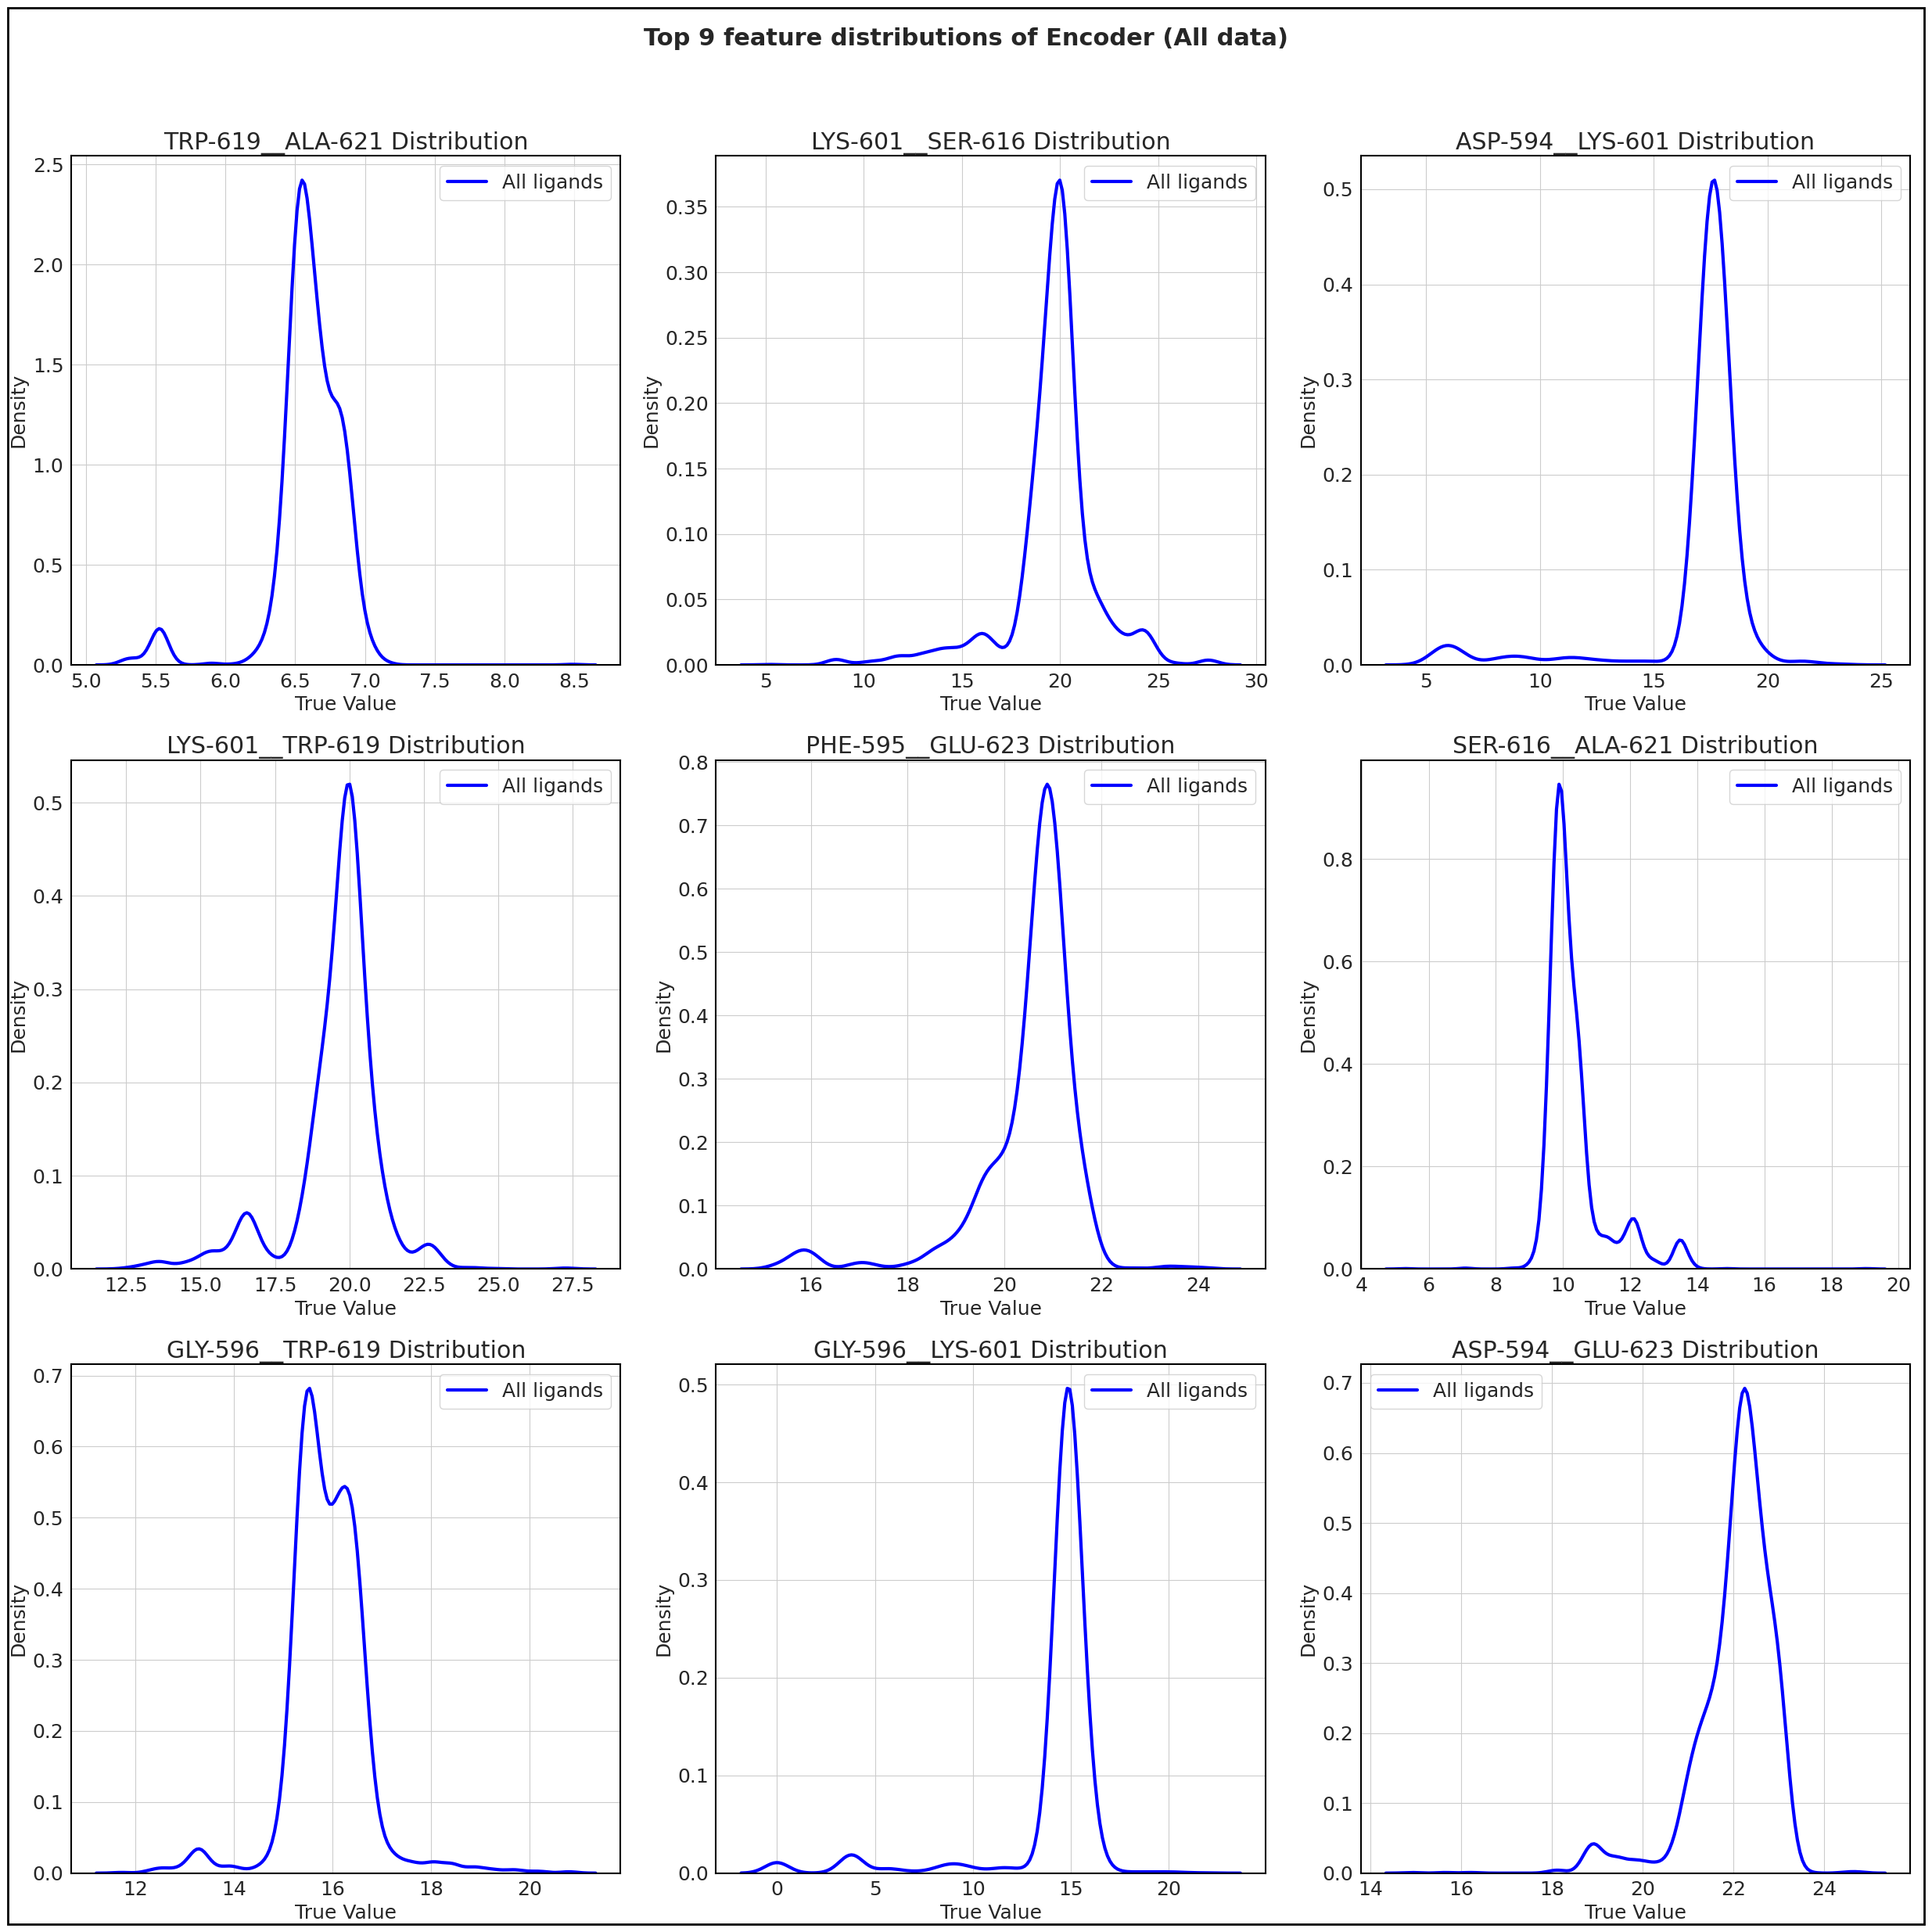

Saved: predict_DFGAPE/encoder_z_predict_dfgape/kde_top9(encoder_z_predict_dfgape).png


In [ ]:
# Path configuration
feature_file = "pairwise_distance_features_DFGAPE.csv"          
out_prefix   = "encoder_z_predict_dfgape"                              
imp_file     = f"predict_DFGAPE/{out_prefix}/feature_importances_sorted_DFGAPE.csv"

map_file     = "pairwise_distance_feature_map_DFGAPE.csv"       

# Load the full feature table and the importance ranking
df_all = pd.read_csv(feature_file)                       

imp = pd.read_csv(imp_file)

# Determine which column name to use for labeling 
name_col = "residue_pair" if "residue_pair" in imp.columns else \
           ("feature" if "feature" in imp.columns else "column_name")

if "column_name" not in imp.columns and os.path.exists(map_file):
    fmap = pd.read_csv(map_file)  
    if name_col == "residue_pair" and "residue_pair" in fmap.columns:
        imp = imp.merge(fmap[["residue_pair", "column_name"]], on="residue_pair", how="left")
    elif name_col == "feature" and "column_name" in fmap.columns:
        imp = imp.merge(fmap[["column_name"]], on="column_name", how="left")

# Select the top-9 most important features
topK = 9
imp_top = imp.nlargest(topK, "importance").copy()
top_feature_names_for_plot = imp_top[name_col].tolist()           
top_columns_for_data       = imp_top["column_name"].tolist()      

# Filter columns that are present in the dataset
top_mask = [c in df_all.columns for c in top_columns_for_data]
top_feature = [n for n, m in zip(top_feature_names_for_plot, top_mask) if m]
top_cols    = [c for c, m in zip(top_columns_for_data, top_mask) if m]

# Extract the top feature columns from the dataset
df = df_all[top_cols].copy()

# Set seaborn plot style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(25, 25))

# Plot the distribution of each top feature
for i, (feature_name, data_col) in enumerate(zip(top_feature, top_cols)):
    ax = plt.subplot(3, 3, i+1)  

    x_all = pd.to_numeric(df[data_col], errors="coerce").dropna()

    # Use KDE plot if values vary; otherwise use histogram
    if x_all.nunique() >= 2:
        sns.kdeplot(x_all, color='blue',  label='All ligands', linewidth=3, ax=ax)
    else:
        ax.hist(x_all, bins=20, density=True, color='blue', alpha=0.3, label='All ligands')


    ax.set_title(f'{feature_name} Distribution')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Density')
    ax.legend()

    for sp in ax.spines.values():
        sp.set_visible(True)
        sp.set_edgecolor('black')
        sp.set_linewidth(1.5)

# Add global title and layout adjustments
plt.suptitle(f"Top {topK} feature distributions of Encoder (All data)", fontsize=22, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

fig = plt.gcf()
fig.add_artist(Rectangle((0.01, 0.01), 0.98, 0.98,
                         transform=fig.transFigure, fill=False,
                         edgecolor='black', linewidth=2, zorder=1000, clip_on=False))

out_path = os.path.join("predict_DFGAPE", out_prefix, f"kde_top{topK}({out_prefix}).png")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.savefig(out_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
print(f"Saved: {out_path}")

Feature values with encoder z1/z2 saved to: predict_DFGAPE/encoder_z_predict_dfgape/features_with_z1_z2_top9_dfgape.csv


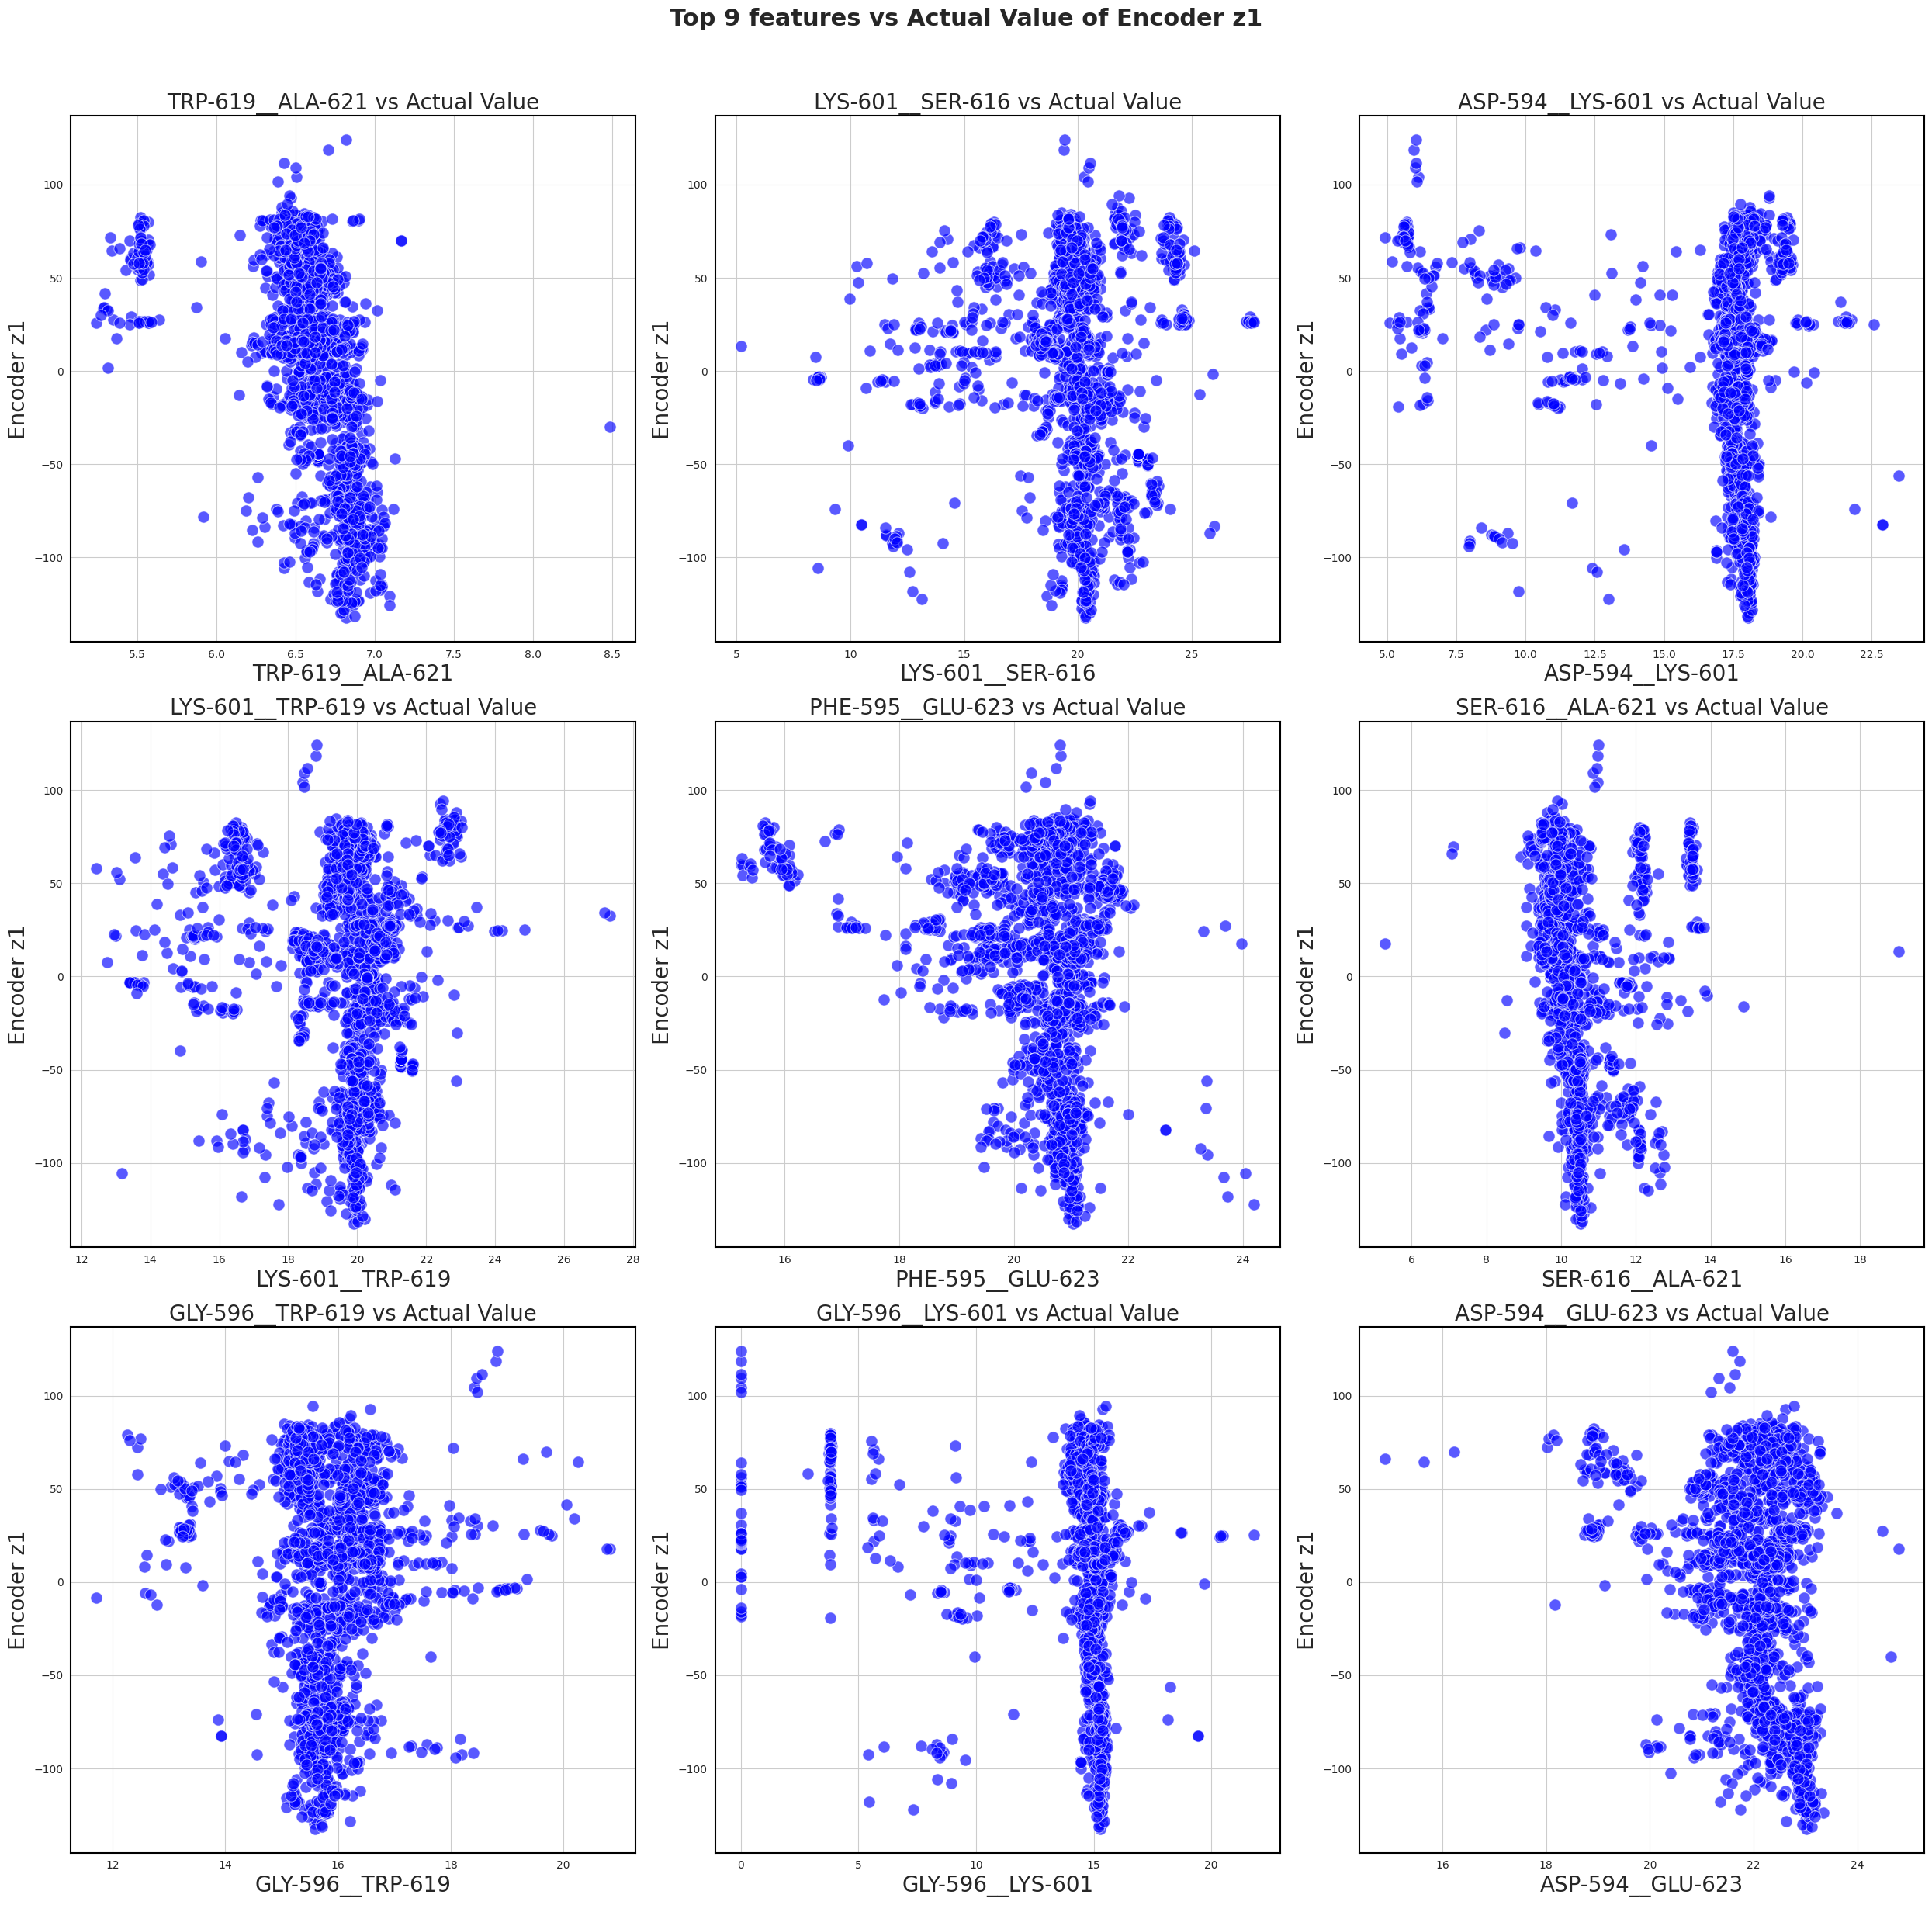

Saved: predict_DFGAPE/encoder_z_predict_dfgape/scatter_top9_vs_z1(encoder_z_predict_dfgape)_DFGAPE.png


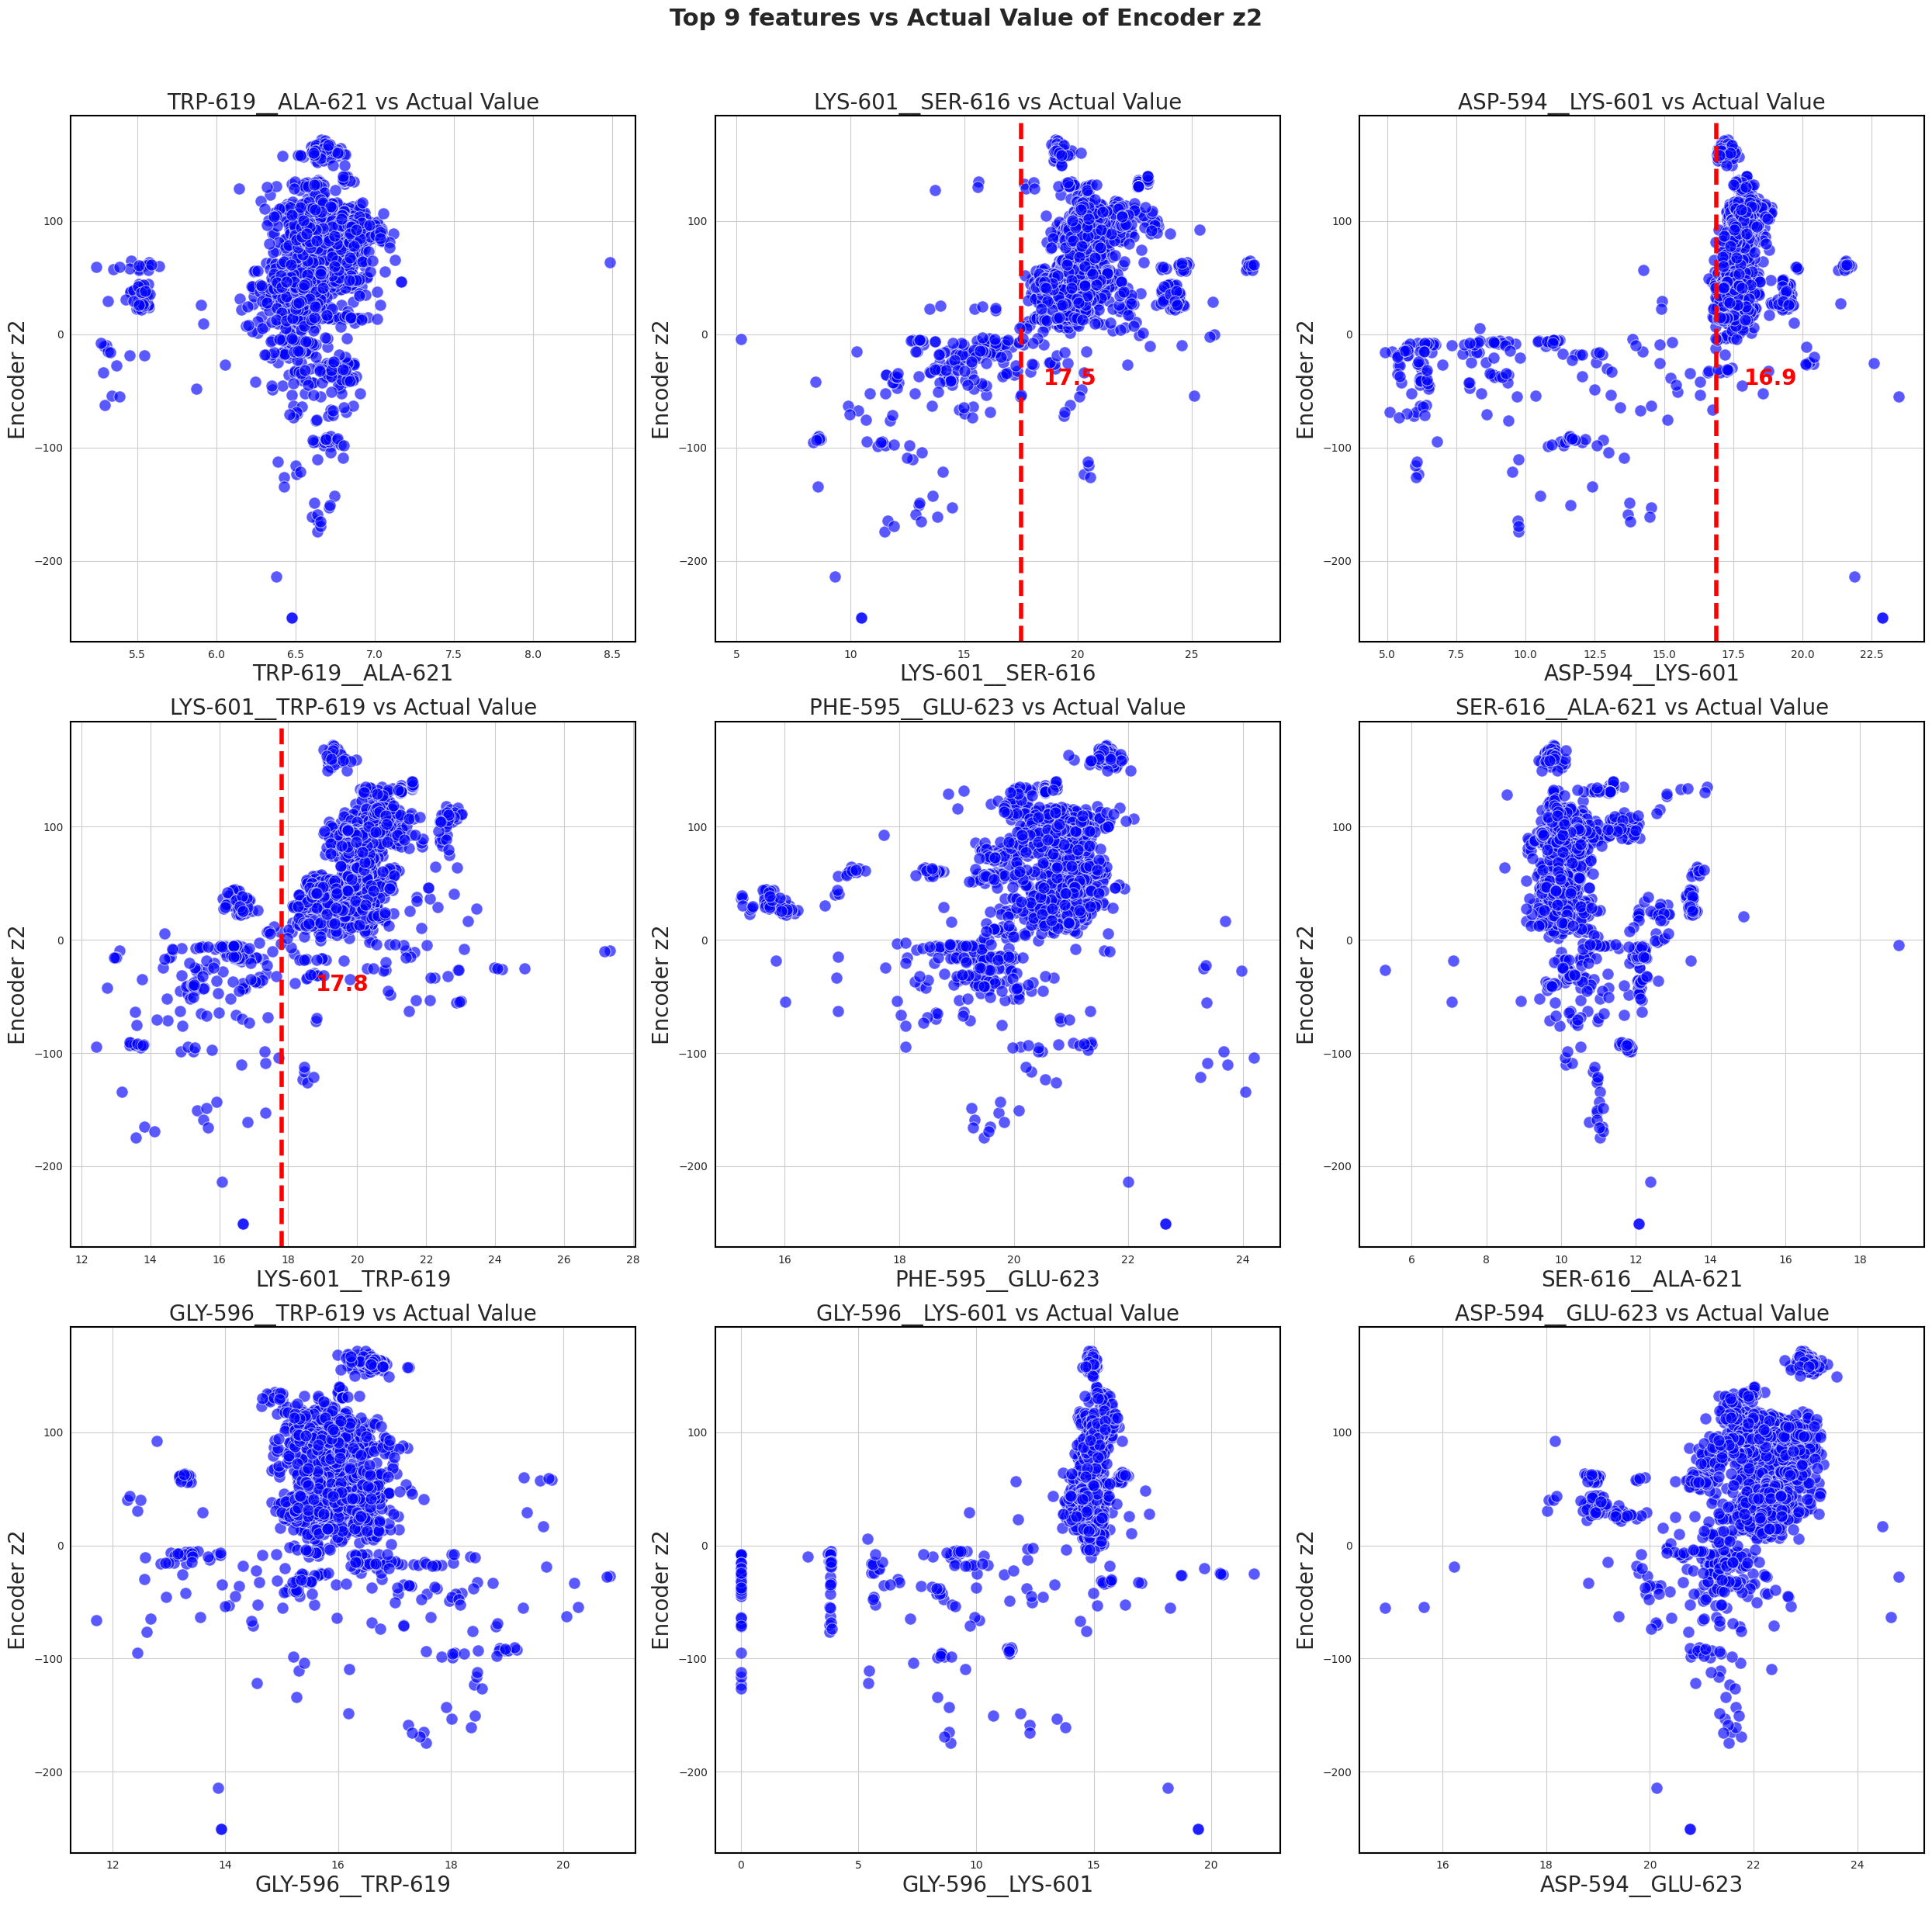

Saved: predict_DFGAPE/encoder_z_predict_dfgape/scatter_top9_vs_z2(encoder_z_predict_dfgape)_DFGAPE.png


In [ ]:
# Read 2D encoder latent coordinates (z1, z2) from training and test CSV files
enc_train_csv = "Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv"
enc_test_csv  = "Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv"

df_tr = pd.read_csv(enc_train_csv)
df_te = pd.read_csv(enc_test_csv)
enc_df = pd.concat([df_tr, df_te], ignore_index=True)

# Rename columns to standard names for z1, z2, and PDB file name
rename_map = {}
for col in enc_df.columns:
    cs = str(col).strip()
    if cs == '0': rename_map[col] = 'z1'
    elif cs == '1': rename_map[col] = 'z2'
    elif 'pdb' in cs.lower(): rename_map[col] = 'pdb_filename'
    elif 'index' in cs.lower(): rename_map[col] = 'idx'
enc_df = enc_df.rename(columns=rename_map)

# Remove ".pdb" extension for merging
enc_df["PDB_Name"] = (
    enc_df["pdb_filename"].astype(str).str.strip().str.replace(".pdb", "", regex=False)
)

# Merge top-K feature values with their corresponding z1/z2 encoder values
need_cols = ["PDB_Name"] + top_cols[:topK]
df_all_for_scatter = pd.merge(
    df_all[need_cols], enc_df[["PDB_Name", "z1", "z2"]],
    on="PDB_Name", how="inner"
)

save_cols = ["PDB_Name"] + top_cols[:topK] + ["z1", "z2"]
out_csv = os.path.join("predict_DFGAPE", "encoder_z_predict_dfgape", f"features_with_z1_z2_top{topK}_dfgape.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_all_for_scatter[save_cols].to_csv(out_csv, index=False)
print(f"Feature values with encoder z1/z2 saved to: {out_csv}")

# Function to scatter plot each top feature vs encoder latent dimension (z1 or z2)
def plot_feature_vs_dim(dim_col: str, y_label: str, save_suffix: str, out_prefix: str):
    fig, axes = plt.subplots(3, 3, figsize=(25, 25))
    sns.set_style("whitegrid")

    for i, (feat_name, data_col) in enumerate(zip(top_feature[:topK], top_cols[:topK])):
        r, c = divmod(i, 3)
        ax = axes[r, c]

        # Scatter plot of feature value vs z1 or z2
        ax.scatter(
            df_all_for_scatter[data_col], df_all_for_scatter[dim_col],
            s=120, c='blue', alpha=0.65, edgecolors='white', linewidths=0.7,
            label='All ligands'
        )

        # For specific z2-related features, add vertical threshold lines
        if dim_col=="z2":
            if i == 1:  
                ax.axvline(x=17.5, color='red', linestyle='--', linewidth=4)
                y_mid = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2   
                ax.text(17.5 + 1, y_mid, "17.5", color='red', fontsize=20,
            ha='left', va='center', fontweight='bold')
                
            if i == 2:  
                ax.axvline(x=16.9, color='red', linestyle='--', linewidth=4)
                y_mid = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2   
                ax.text(16.9 + 1, y_mid, "16.9", color='red', fontsize=20,
            ha='left', va='center', fontweight='bold')
                
            if i == 3:  
                ax.axvline(x=17.8, color='red', linestyle='--', linewidth=4)
                y_mid = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2   
                ax.text(17.8 + 1, y_mid, "17.8", color='red', fontsize=20,
            ha='left', va='center', fontweight='bold')

        ax.set_title(f'{feat_name} vs Actual Value', fontsize=20)
        ax.set_xlabel(feat_name, fontsize=20)       
        ax.set_ylabel(y_label, fontsize=20)

        for sp in ax.spines.values():
            sp.set_visible(True)
            sp.set_edgecolor('black')
            sp.set_linewidth(1.5)

        if not (r == 0 and c == 0) and ax.get_legend():
            ax.get_legend().remove()

    # Add a shared title and adjust spacing
    fig.suptitle(f"Top {topK} features vs Actual Value of {y_label}", fontsize=22, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the plot as a high-resolution PNG
    out_path = os.path.join("predict_DFGAPE", out_prefix, f"scatter_top{topK}_vs_{save_suffix}({out_prefix})_DFGAPE.png")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    print(f"Saved: {out_path}")

plot_feature_vs_dim("z1", "Encoder z1", "z1", "encoder_z_predict_dfgape")
plot_feature_vs_dim("z2", "Encoder z2", "z2","encoder_z_predict_dfgape")


In [ ]:

import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde  

#paths
feature_file = "pairwise_distance_features_DFGAPE.csv"                
out_prefix   = "encoder_z_predict_dfgape"
imp_file     = f"predict_DFGAPE/{out_prefix}/feature_importances_sorted_DFGAPE.csv"
map_file     = "pairwise_distance_feature_map_DFGAPE.csv"             

# 2D target (encoder z1, z2)
enc_train_csv = "Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv"
enc_test_csv  = "Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv"

# KDE and output parameters
Z2_THR   = 0.0      
BW       = 0.8       
SAVE_DIR = Path("predict_DFGAPE") / out_prefix / "kde_split_by_z2"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Utility function to sanitize feature names for file saving
def safe_name(s: str) -> str:
    return re.sub(r"[^\w\-]+", "_", str(s))

# Load full feature matrix and feature importance table
df_all = pd.read_csv(feature_file)
imp = pd.read_csv(imp_file)

# Determine which name column to use for displaying features
name_col = "residue_pair" if "residue_pair" in imp.columns else ("feature" if "feature" in imp.columns else "column_name")

# If column name mapping is missing, try to load it from mapping file
if "column_name" not in imp.columns and os.path.exists(map_file):
    fmap = pd.read_csv(map_file)
    if name_col == "residue_pair" and "residue_pair" in fmap.columns:
        imp = imp.merge(fmap[["residue_pair", "column_name"]], on="residue_pair", how="left")
    elif name_col == "feature" and "column_name" in fmap.columns:
        imp = imp.merge(fmap[["column_name"]], on="column_name", how="left")

# Select the top-ranked features by importance (e.g., index 1 and 2)
imp_sorted = imp.sort_values("importance", ascending=False).reset_index(drop=True)
pick_idx   = [1, 2]
imp_pick   = imp_sorted.loc[pick_idx].copy()

# Extract feature display names and corresponding column names
feat_names = imp_pick[name_col].tolist()
feat_cols  = imp_pick["column_name"].tolist()

# Filter out features not present in the main dataset
mask = [c in df_all.columns for c in feat_cols]
feat_names = [n for n, m in zip(feat_names, mask) if m]
feat_cols  = [c for c, m in zip(feat_cols,  mask) if m]

df_tr = pd.read_csv(enc_train_csv)
df_te = pd.read_csv(enc_test_csv)
enc_df = pd.concat([df_tr, df_te], ignore_index=True)

# Rename encoder columns to standard format
rename_map = {}
for col in enc_df.columns:
    cs = str(col).strip()
    if cs == '0': rename_map[col] = 'z1'
    elif cs == '1': rename_map[col] = 'z2'
    elif 'pdb' in cs.lower(): rename_map[col] = 'pdb_filename'
    elif 'index' in cs.lower(): rename_map[col] = 'idx'
enc_df = enc_df.rename(columns=rename_map)

enc_df["PDB_Name"] = enc_df["pdb_filename"].astype(str).str.strip().str.replace(".pdb", "", regex=False)

# Merge feature values with corresponding z2 values
need_cols = ["PDB_Name"] + feat_cols
df_feat_z2 = pd.merge(df_all[need_cols], enc_df[["PDB_Name", "z1", "z2"]], on="PDB_Name", how="inner")

# KDE peak utility: returns peak x/y and evaluated KDE line
def kde_peak(x, bw_adjust=0.8, grids=512):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.nan, np.nan, None, None
    kde = gaussian_kde(x, bw_method='scott')
    kde.set_bandwidth(kde.factor * bw_adjust)
    lo, hi = x.min(), x.max()
    pad = 0.1 * max(1e-6, (hi - lo))
    xs = np.linspace(lo - pad, hi + pad, grids)
    ys = kde(xs)
    i = int(np.argmax(ys))
    return float(xs[i]), float(ys[i]), xs, ys

sns.set_style("whitegrid")

# Loop over selected features for plotting
for fname, fcol in zip(feat_names, feat_cols):
    sub = df_feat_z2[[fcol, "z2"]].replace([np.inf, -np.inf], np.nan).dropna()
    x_low  = sub.loc[sub["z2"] <  Z2_THR, fcol].astype(float)
    x_high = sub.loc[sub["z2"] >= Z2_THR, fcol].astype(float)

    if len(x_low) < 2 and len(x_high) < 2:
        print(f"[Skip] {fname}: not enough data.")
        continue

    # Compute KDE for z2 < 0 and z2 > 0 groups
    px1, py1, xs1, ys1 = kde_peak(x_low,  BW)
    px2, py2, xs2, ys2 = kde_peak(x_high, BW)

    fig, ax = plt.subplots(figsize=(7.2, 5.2))

    if xs1 is not None:
        ax.plot(xs1, ys1, color="#1f77b4", lw=2, label="z2 < 0")
    if xs2 is not None:
        ax.plot(xs2, ys2, color="#ff7f0e", lw=2, label="z2 > 0")

    ax.relim(); ax.autoscale()
    y0, y1 = ax.get_ylim(); yspan = (y1 - y0)

    # Plot vertical lines and labels for KDE peaks
    if np.isfinite(px1):
        ax.vlines(px1, 0, py1, color="#1f77b4", ls="--", lw=1.2, alpha=0.9)
        ax.text(px1, min(py1 + 0.007*yspan, y1 - 0.02*yspan),
                f"{px1:.2f}", color="#1f77b4", fontsize=11, ha="center", va="bottom")
    if np.isfinite(px2):
        ax.vlines(px2, 0, py2, color="#ff7f0e", ls="--", lw=1.2, alpha=0.9)
        ax.text(px2, min(py2 + 0.007*yspan, y1 - 0.02*yspan),
                f"{px2:.2f}", color="#ff7f0e", fontsize=11, ha="center", va="bottom")

    ax.set_title(f"{fname} distribution split by z2 (threshold = 0)")
    ax.set_xlabel(fname)     
    ax.set_ylabel("Density")
    ax.legend()

    # Style the plot frame
    for sp in ax.spines.values():
        sp.set_visible(True); sp.set_edgecolor('black'); sp.set_linewidth(1.0)

    out_png = SAVE_DIR / f"kde_split_{safe_name(fname)}_DFGAPE.png"
    fig.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)
    print(f"Saved: {out_png}")


Saved: predict_DFGAPE/encoder_z_predict_dfgape/kde_split_by_z2/kde_split_LYS-601__SER-616_DFGAPE.png
Saved: predict_DFGAPE/encoder_z_predict_dfgape/kde_split_by_z2/kde_split_ASP-594__LYS-601_DFGAPE.png
